In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from ISLP import confusion_table

# Step 1: Load and Preprocess Data
data = pd.read_csv('pc3_and_pc4_training_data_large_v1.csv')
df_train = data.drop(columns=['listed_date', 'width', 'exterior_color', 'latitude', 'longitude', 'engine_displacement', 'wheel_system', 'length', 'wheelbase', 'height'])

cols_to_clean = ['back_legroom']
#df_train[cols_to_clean] = df_train[cols_to_clean].replace({' in': ''}, regex=True)

#for column in cols_to_clean:
#    df_train[column] = df_train[column].str.replace(" in", "").astype(float)
#    average_value = df_train[column].mean()
#    df_train[column] = df_train[column].replace("--", average_value)

# Fill missing entries with NaN
for column in cols_to_clean:
    df_train[column] = df_train[column].replace("--", np.nan).str.replace(" in", "").astype(float)

# Fill missing entries with the average of the column
for column in cols_to_clean:
    average_value = df_train[column].mean()
    df_train[column] = df_train[column].fillna(average_value)

# Create binary variable
df_train['binary_price'] = (df_train['price'] < 19500).astype(int)

# Extract features and target variable
y_full = df_train['binary_price']  # Target variable
X_full = df_train.drop(['price', 'binary_price'], axis=1)  # Features

FileNotFoundError: [Errno 2] No such file or directory: 'pc3_and_pc4_training_data_large_v1.csv'

In [6]:
# Handle categorical columns using one-hot encoding
#categorical_columns = ['body_type', 'exterior_color', 'fuel_type', 'wheel_system']
categorical_columns = ['body_type', 'fuel_type']

# Define the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), make_column_selector(dtype_exclude="object")),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_columns)
    ])

#preprocessor = ColumnTransformer(
#    transformers=[
#        ('num', StandardScaler(), df_train.columns.difference(categorical_columns)),
#        ('cat', ColumnTransformer(
#                    transformers=[
#                        ('imputer', SimpleImputer(strategy='most_frequent'), categorical_columns),
#                        ('encoder', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
#                    ], 
#                    remainder='passthrough'), categorical_columns)
#    ])

In [7]:
# Normalization/Scaling
#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)
X_transformed = preprocessor.fit_transform(X_full)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y_full, test_size=0.2, random_state=42)

In [8]:
best_accuracy = 0
best_neighbors = 0

for neighbors in range(7, 13):
    # KNN Model training
    knn_model = KNeighborsClassifier(n_neighbors=neighbors)
    knn_model.fit(X_train, y_train)

    # Make predictions
    y_pred = knn_model.predict(X_test)

    # Evaluate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Update best parameters if needed
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_neighbors = neighbors

    print(f"Neighbors: {neighbors}, Accuracy: {accuracy}")

# Print the best parameters
print(f"Best Accuracy: {best_accuracy}")
print(f"Number of Neighbors: {best_neighbors}")

Neighbors: 7, Accuracy: 0.91697
Neighbors: 8, Accuracy: 0.91597
Neighbors: 9, Accuracy: 0.91693
Neighbors: 10, Accuracy: 0.91623
Neighbors: 11, Accuracy: 0.91764
Neighbors: 12, Accuracy: 0.91683
Best Accuracy: 0.91764
Number of Neighbors: 11


In [12]:
from sklearn.metrics import confusion_matrix

knn_model = KNeighborsClassifier(n_neighbors=best_neighbors)
knn_model.fit(X_train, y_train)

y_pred = knn_model.predict(X_test)

#conf_matrix = confusion_matrix(y_test, y_pred)
#print(conf_matrix)
table = confusion_table(y_test, y_pred)
print(table)
#tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
#print(fp)

Truth         0     1
Predicted            
0          8997   826
1           647  9530


In [13]:
from tabulate import tabulate

conf_table = [
    ['Actual', 0, 1],
      ['Predicted', '', ''],
      [0, 45165, 3714],
      [1, 3240, 47881]
]

print(tabulate(conf_table))

---------  -----  -----
Actual     0      1
Predicted
0          45165  3714
1          3240   47881
---------  -----  -----


In [7]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.92635

In [49]:
test_data = pd.read_csv('pc3_test_data_without_response_v1.csv')
df_test = test_data.drop(columns=['listed_date', 'width', 'exterior_color', 'latitude', 'longitude', 'engine_displacement', 'wheel_system', 'length', 'wheelbase', 'height'])

#cols_to_clean = ['back_legroom']

for column in cols_to_clean:
    df_test[column] = df_test[column].replace("--", np.nan).str.replace(" in", "").astype(float)

# Fill missing entries with the average of the column
for column in cols_to_clean:
    average_value = df_test[column].mean()
    df_test[column] = df_test[column].fillna(average_value)

X_testing = df_test.drop(['price'], axis=1)
X_final = preprocessor.fit_transform(X_testing)

knn_model = KNeighborsClassifier(n_neighbors=best_neighbors)
knn_model.fit(X_train, y_train)

final_pred = knn_model.predict(X_final)
final_pred = pd.DataFrame(final_pred)

In [50]:
final_pred.to_csv("final_preds.csv", index=False, header=False)

In [ ]:
test_errors = []
train_errors = []

for neighbors in range(1, 41):
    # KNN Model training
    knn_model = KNeighborsClassifier(n_neighbors=neighbors)
    knn_model.fit(X_train, y_train)

    # Make predictions
    y_pred = knn_model.predict(X_test)
    y_pred2 = knn_model.predict(X_train)

    # Evaluate accuracy
    error = 1 - accuracy_score(y_test, y_pred)
    error2 = 1 - accuracy_score(y_train, y_pred2)

    test_errors.append(error)
    train_errors.append(error2)

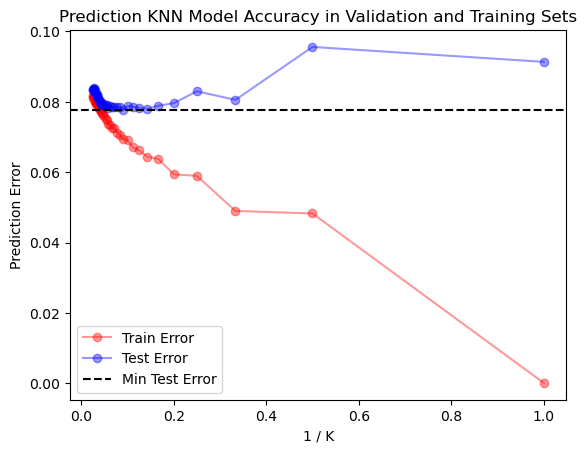

Best Number of Neighbors: 11
Best Accuracy: 92.22%


In [6]:
# Plot the errors
k_vals = 1 / np.arange(1, 41)
minTestError = min(test_errors)
plt.plot(k_vals, train_errors, color="red", marker='o', alpha=0.4, label='Training Set Error')
plt.plot(k_vals, test_errors, color="blue", marker='o', alpha=0.4, label='Test Set Error')
plt.axhline(y=minTestError, color="black", linestyle="--", label='Min Test Error')
plt.xlabel('1 / K')
plt.ylabel('Prediction Error')
plt.title('Prediction KNN Model Accuracy in Validation and Training Sets')
plt.legend()
plt.show()

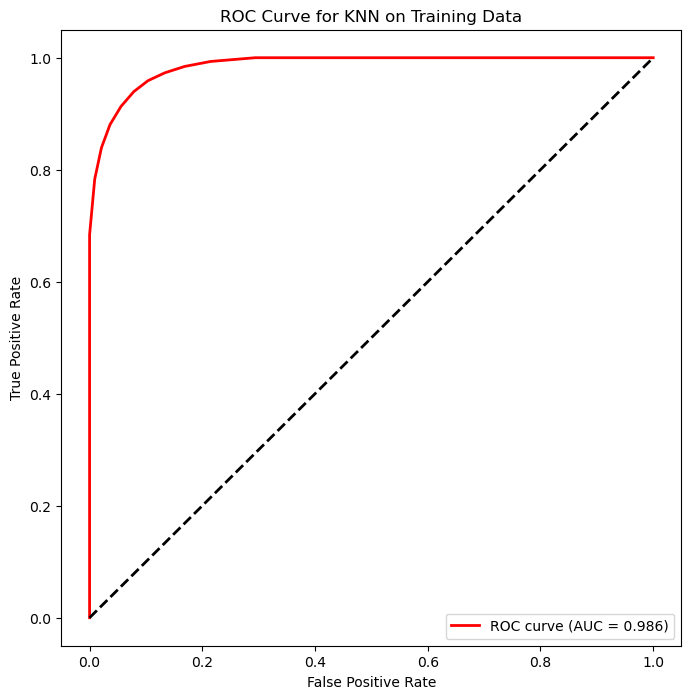

In [22]:
from sklearn.metrics import roc_curve, roc_auc_score

knn_model = KNeighborsClassifier(n_neighbors=best_neighbors)
knn_model.fit(X_train, y_train)

y_probs = knn_model.predict_proba(X_train)[:, 1]

fpr, tpr, thresholds = roc_curve(y_train, y_probs)
roc_auc = roc_auc_score(y_train, y_probs)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for KNN on Training Data')
plt.legend(loc="lower right")
plt.show()

In [55]:
import seaborn as sns

thresholds = np.linspace(0, 0.65, 25)

y_probs = knn_model.predict_proba(X_train)[:, 1]

fp_rates = []
fn_rates = []
err_rates = []

#threshold = 0.01
for threshold in thresholds:
    #if threshold == 1:
    #    threshold = 1.1
    y_pred = (y_probs >= threshold).astype(int)
    #print(y_probs[1], threshold, y_pred[1])
    tn, fp, fn, tp = confusion_matrix(y_train, y_pred).ravel()
    #print(confusion_matrix(y_train, y_pred))

    false_positive = fp / (fp + tn)
    false_negative = fn / (fn + tp)
    overall_error = (fp + fn) / (tp + tn + fp + fn)

    #print(false_positive)
    #print(false_negative)
    #print(overall_error)

    fp_rates.append(false_positive)
    fn_rates.append(false_negative)
    err_rates.append(overall_error)

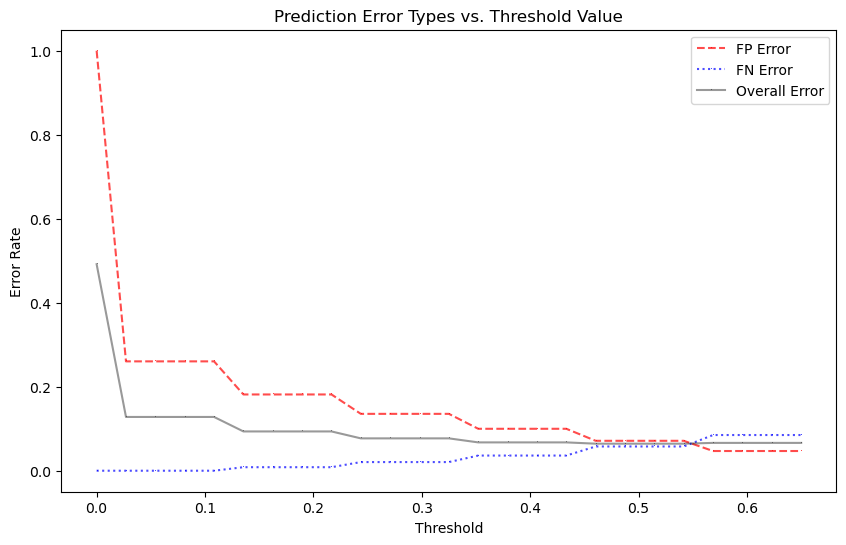

In [56]:
plt.figure(figsize=(10, 6))
plt.plot(thresholds, fp_rates, color="red", linestyle='--', marker=',', alpha=0.7, label='FP Error')
plt.plot(thresholds, fn_rates, color="blue", linestyle=':', marker=',', alpha=0.7, label='FN Error')
plt.plot(thresholds, err_rates, color="black", marker=',', alpha=0.4, label='Overall Error')
plt.xlabel('Threshold')
plt.ylabel('Error Rate')
plt.title('Prediction Error Types vs. Threshold Value')
plt.legend()
plt.show()

In [19]:
print(thresholds)

[0.         0.02040816 0.04081633 0.06122449 0.08163265 0.10204082
 0.12244898 0.14285714 0.16326531 0.18367347 0.20408163 0.2244898
 0.24489796 0.26530612 0.28571429 0.30612245 0.32653061 0.34693878
 0.36734694 0.3877551  0.40816327 0.42857143 0.44897959 0.46938776
 0.48979592 0.51020408 0.53061224 0.55102041 0.57142857 0.59183673
 0.6122449  0.63265306 0.65306122 0.67346939 0.69387755 0.71428571
 0.73469388 0.75510204 0.7755102  0.79591837 0.81632653 0.83673469
 0.85714286 0.87755102 0.89795918 0.91836735 0.93877551 0.95918367
 0.97959184 1.        ]


In [23]:
thresholds = np.linspace(0, 1, 50)
y_probs = knn_model.predict_proba(X_train)[:, 1]

print(y_probs[0])
#print(y_probs[1])

threshold = 0
y_pred = (y_probs >= threshold).astype(int)
tn, fp, fn, tp = confusion_matrix(y_train, y_pred).ravel()

false_positive = fp / (fp + tn)
false_negative = fn / (fn + tp)
overall_error = (fp + fn) / (tp + tn + fp + fn)

print(confusion_matrix(y_train, y_pred))
print(false_positive)
print(false_negative)

1.0
[[    0 39336]
 [    0 40664]]
1.0
0.0
